In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip -q install timm pandas scikit-learn tqdm


In [3]:
from pathlib import Path
import json, time, random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from PIL import Image

import timm
from tqdm import tqdm

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [4]:
PROJECT_ROOT = Path("/content/drive/MyDrive/SkinCare_AI_Component")

META_DIR = PROJECT_ROOT / "data/11_skin_type/metadata"
INDEX_CSV = META_DIR / "image_index_skin_type.csv"
LABEL_MAP_JSON = META_DIR / "label_map_skin_type.json"

OUT_MODELS  = PROJECT_ROOT / "models/vision"
OUT_METRICS = PROJECT_ROOT / "results/metrics"
OUT_CM      = PROJECT_ROOT / "results/confusion_matrices"

OUT_MODELS.mkdir(parents=True, exist_ok=True)
OUT_METRICS.mkdir(parents=True, exist_ok=True)
OUT_CM.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "mobilenetv3_large_100"   # ✅ MobileNet
MODEL_OUT  = OUT_MODELS / "skin_type_mobilenet_best.pt"

METRICS_OUT = OUT_METRICS / "skin_type_mobilenet_metrics.json"
CM_OUT      = OUT_CM / "skin_type_mobilenet_confusion_matrix_counts.png"
CM_PCT_OUT  = OUT_CM / "skin_type_mobilenet_confusion_matrix_percent.png"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

df = pd.read_csv(INDEX_CSV)
with open(LABEL_MAP_JSON, "r") as f:
    label_map = json.load(f)

id_to_label = {v: k for k, v in label_map.items()}
num_classes = len(label_map)

print("Classes:", label_map)
print("Total samples:", len(df))


Device: cuda
Classes: {'oily': 0, 'dry': 1, 'combination': 2}
Total samples: 7019


In [5]:
df_train = df[df["split"] == "train"].copy()
df_val   = df[df["split"] == "val"].copy()
df_test  = df[df["split"] == "test"].copy()

print("Split sizes:", len(df_train), len(df_val), len(df_test))
assert len(df_train) > 0 and len(df_val) > 0 and len(df_test) > 0


Split sizes: 4978 1008 1033


In [6]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20          # 🔺 more epochs
LR = 2e-4            # 🔺 higher LR
WEIGHT_DECAY = 1e-4
NUM_WORKERS = 2

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)


In [7]:
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(
        [transforms.ColorJitter(0.15, 0.15, 0.10, 0.02)], p=0.6
    ),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

class SkinTypeDataset(Dataset):
    def __init__(self, df_, tfm):
        self.df = df_.reset_index(drop=True)
        self.tfm = tfm

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        img = Image.open(PROJECT_ROOT / r["image_path"]).convert("RGB")
        x = self.tfm(img)
        y = int(r["label_id"])
        return x, y


In [8]:
train_loader = DataLoader(
    SkinTypeDataset(df_train, train_tfms),
    batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)

val_loader = DataLoader(
    SkinTypeDataset(df_val, eval_tfms),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)

test_loader = DataLoader(
    SkinTypeDataset(df_test, eval_tfms),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)


In [9]:
from collections import Counter

counts = Counter(df_train["label_id"].tolist())
print("Train counts:", {id_to_label[k]: v for k, v in counts.items()})

class_weights = np.array([1.0 / counts.get(i, 1) for i in range(num_classes)])
class_weights = class_weights / class_weights.sum() * num_classes
cw = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class weights:", {id_to_label[i]: float(class_weights[i]) for i in range(num_classes)})


Train counts: {'oily': 1764, 'dry': 2100, 'combination': 1114}
Class weights: {'oily': 0.8763005537841919, 'dry': 0.7360924651787212, 'combination': 1.3876069810370866}


In [10]:
model = timm.create_model(
    MODEL_NAME,
    pretrained=True,
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss(weight=cw, label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

total_steps = EPOCHS * len(train_loader)
warmup_steps = int(0.1 * total_steps)

def lr_lambda(step):
    if step < warmup_steps:
        return step / max(1, warmup_steps)
    prog = (step - warmup_steps) / max(1, total_steps - warmup_steps)
    return 0.5 * (1 + np.cos(np.pi * prog))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

/tmp/ipython-input-2078195788.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


In [11]:
def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    correct, total, total_loss = 0, 0, 0.0

    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            with torch.amp.autocast("cuda", enabled=(device.type=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)

            if train:
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()

        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


In [12]:
best_val = 0.0
bad = 0
PATIENCE = 5
history = []

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, True)
    va_loss, va_acc = run_epoch(val_loader, False)

    history.append({
        "epoch": epoch,
        "train_acc": float(tr_acc),
        "val_acc": float(va_acc)
    })

    print(f"Epoch {epoch}/{EPOCHS} | train acc {tr_acc:.4f} | val acc {va_acc:.4f}")

    if va_acc > best_val:
        best_val = va_acc
        bad = 0
        torch.save({
            "model_state": model.state_dict(),
            "model_name": MODEL_NAME,
            "label_map": label_map
        }, MODEL_OUT)
        print("✅ Saved best:", MODEL_OUT)
    else:
        bad += 1
        if bad >= PATIENCE:
            print("⏹️ Early stop")
            break

print("Best val acc:", best_val)


Epoch 1/20 | train acc 0.4673 | val acc 0.4613
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_type_mobilenet_best.pt


Epoch 2/20 | train acc 0.6894 | val acc 0.4603


Epoch 3/20 | train acc 0.7893 | val acc 0.4851
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_type_mobilenet_best.pt


Epoch 4/20 | train acc 0.8532 | val acc 0.4802


Epoch 5/20 | train acc 0.8935 | val acc 0.4464


Epoch 6/20 | train acc 0.9078 | val acc 0.5238
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_type_mobilenet_best.pt


Epoch 7/20 | train acc 0.9156 | val acc 0.5149


Epoch 8/20 | train acc 0.9225 | val acc 0.5020


Epoch 9/20 | train acc 0.9295 | val acc 0.5119


Epoch 10/20 | train acc 0.9417 | val acc 0.5188


Epoch 11/20 | train acc 0.9442 | val acc 0.5337
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_type_mobilenet_best.pt


Epoch 12/20 | train acc 0.9478 | val acc 0.5397
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_type_mobilenet_best.pt


Epoch 13/20 | train acc 0.9518 | val acc 0.5466
✅ Saved best: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_type_mobilenet_best.pt


Epoch 14/20 | train acc 0.9616 | val acc 0.5238


Epoch 15/20 | train acc 0.9642 | val acc 0.5218


Epoch 16/20 | train acc 0.9654 | val acc 0.5208


Epoch 17/20 | train acc 0.9656 | val acc 0.5099


Epoch 18/20 | train acc 0.9709 | val acc 0.5188
⏹️ Early stop
Best val acc: 0.5466269841269841


In [13]:
ckpt = torch.load(MODEL_OUT, map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader):
        x = x.to(device)
        with torch.amp.autocast("cuda", enabled=(device.type=="cuda")):
            logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        y_true.extend(y.numpy())
        y_pred.extend(preds)

acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")
cm = confusion_matrix(y_true, y_pred)

metrics = {
    "model": MODEL_NAME,
    "best_val_acc": best_val,
    "test_accuracy": acc,
    "macro_f1": macro_f1,
    "history": history
}

with open(METRICS_OUT, "w") as f:
    json.dump(metrics, f, indent=2)

print("Test Accuracy:", acc)
print("Macro F1:", macro_f1)


100%|██████████| 33/33 [02:52<00:00,  5.23s/it]

Test Accuracy: 0.4762826718296225
Macro F1: 0.4494439735897025


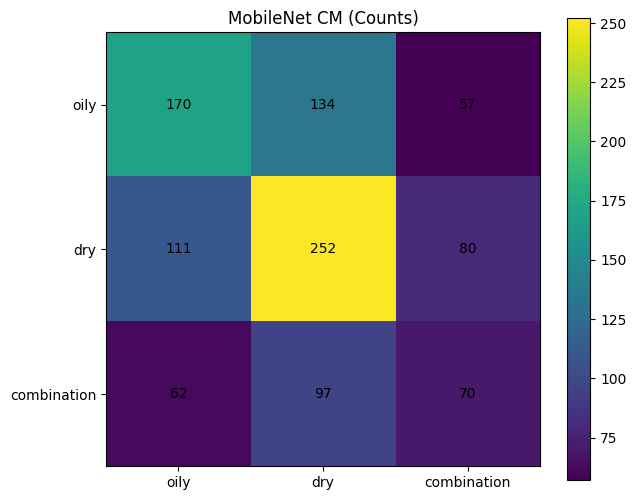

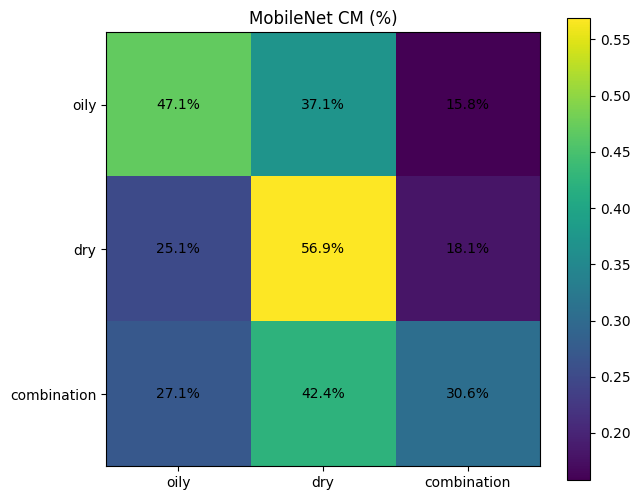

In [14]:
labels = [id_to_label[i] for i in range(num_classes)]

plt.figure(figsize=(7,6))
plt.imshow(cm)
plt.title("MobileNet CM (Counts)")
plt.xticks(range(num_classes), labels)
plt.yticks(range(num_classes), labels)
plt.colorbar()
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, int(cm[i,j]), ha="center", va="center")
plt.savefig(CM_OUT, dpi=250, bbox_inches="tight")
plt.show()

cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(7,6))
plt.imshow(cm_norm)
plt.title("MobileNet CM (%)")
plt.xticks(range(num_classes), labels)
plt.yticks(range(num_classes), labels)
plt.colorbar()
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, f"{cm_norm[i,j]*100:.1f}%", ha="center", va="center")
plt.savefig(CM_PCT_OUT, dpi=250, bbox_inches="tight")
plt.show()
